# Generative Adversarial Networks
### background information
- https://towardsdatascience.com/generative-adversarial-networks-in-python-73d3972823d3

In [1]:
# import libraries
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow.compat.v1 as tf
from tensorflow.python.keras import backend as K

#tf.disable_eager_execution()
tf.disable_v2_behavior()
tf.compat.v1.reset_default_graph()

K.clear_session()


config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# download dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

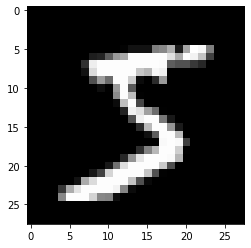

In [7]:
# explore the data
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [5]:
# define generator model
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

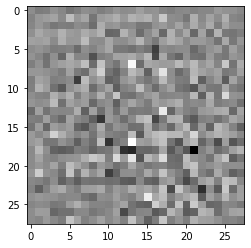

In [6]:
generator = generator_model()
noise = tf.random.normal([1, 100])

your_session = K.get_session()
generated_image = generator(noise, training=False)
array = generated_image[0, :, :, 0].eval(session=your_session)

plt.imshow(array, cmap='gray')
plt.show()

In [7]:
# define discriminator model

def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
discriminator = discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

In [13]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([1, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
from IPython import display

In [16]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
import time
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):

    train_step(dataset)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
train(train_images, EPOCHS)

RuntimeError: Attempting to capture an EagerTensor without building a function.